In [12]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

Data = pd.read_csv('Telco-Customer-Churn.csv')
Data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
#Derive the retention rate
loyal=Data[Data.Churn=='No']
retention_rate=len(loyal)/len(Data)
retention_rate

0.7346301292063041

The origin idea to calculate the CLV is to calculate the difference between the discounted value of gross contribution per customer and the discounted value of retention costs per customer per year. The formula is shown below:

$
\begin{equation} 
CLV = GC \sum_{i=1}^{n} \frac{r^i}{(1+d)^i}- M \sum_{i=1}^{n} \frac{r^{i-1}}{(1+d)^{i-0.5}}
\end{equation}
$

In this case, GC stands for monthly gross contribution per customer, M means the retention costs per customer per month, n is the horizon (in years), r is the monthly retention rate and d is the monthly discount rate.In this case, we assume that the retention rate as a constant.

But, unfortunately, we can't estimate the retention cost based on the data we have. So we just add another assumption to deal with it.We assume that every customer will have an infinite economic life. In other words, $n \rightarrow \infty$.Now, we can simplify the equation above as below:

$
\begin{equation} 
CLV = GC \frac{r}{1+d-r}
\end{equation}
$


The current interest rate is sometimes used as a simple (but incorrect) proxy for discount rate. Now we choose to use the one-month yield of the government bonds as approximation for the discount rate because we only have the monthly charges in the dataset. Data source is from "http://www.worldgovernmentbonds.com/country/united-states/".

In [14]:
dis_rate_us=0.02438

factor_us=retention_rate/(1-retention_rate+dis_rate_us)

In [15]:
def discountvalue(D,T):
    return (D*(1+dis_rate_us)/dis_rate_us)*(1-np.power(1+dis_rate_us,-T))

disvalue=[]
for j in range(0,len(loyal)):
    disvalue.append(discountvalue(Data.MonthlyCharges.values[j],Data.tenure.values[j]))

disvalue=pd.Series(disvalue,index=loyal.index)
    
CLV_aftertenure=loyal.MonthlyCharges*factor_us


CLV=disvalue+CLV_aftertenure
CLV=pd.DataFrame(CLV,index=loyal.index,columns=['CLV'])

In [16]:
loyal=pd.concat([loyal,CLV],axis=1)

In [17]:
loyal_top10=loyal[loyal.CLV>=loyal.CLV.quantile(0.9)]
loyal_top50=loyal[loyal.CLV>=loyal.CLV.quantile(0.5)]

Now, we selected the top 10% loyal customers, who will spend most money on our company.In other words, they are our VIP customers.Now, we are going to analyze their consumption habits and do the comparision with the average loyal customers.

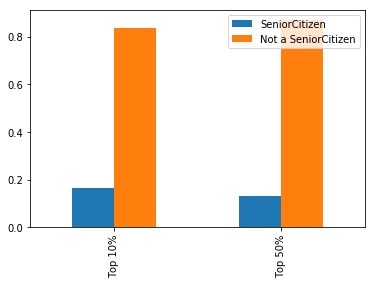

In [32]:
# distribution of the senior citizens in the loyal customer group 
Age = pd.DataFrame([[len(loyal_top10[loyal_top10.SeniorCitizen == 1])/len(loyal_top10), 
                     len(loyal_top10[loyal_top10.SeniorCitizen == 0])/len(loyal_top10)],
                    [len(loyal_top50[loyal_top50.SeniorCitizen == 1])/len(loyal_top50), 
                     len(loyal_top50[loyal_top50.SeniorCitizen == 0])/len(loyal_top50)]],
                        index = ['Top 10%', 'Top 50%'],
                        columns = ['SeniorCitizen', 'Not a SeniorCitizen'])

Age.plot.bar()

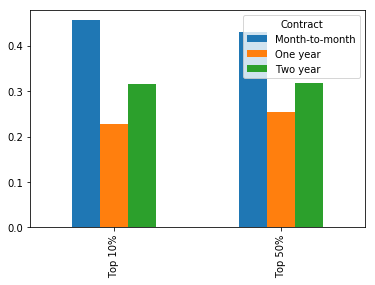

In [33]:
# distribution in the contract within the loyal customers
Contract = pd.DataFrame([loyal_top10.groupby('Contract').count().customerID/len(loyal_top10), 
                         loyal_top50.groupby('Contract').count().customerID/len(loyal_top50)],
                       index = ['Top 10%', 'Top 50%'])

Contract.plot.bar()

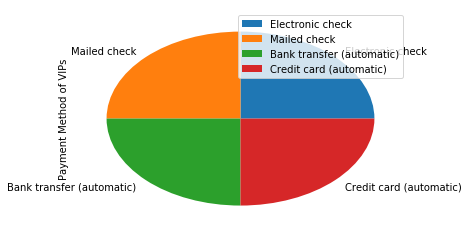

In [25]:
# Distribution of the payment methods of vip
Payment = pd.DataFrame({'Payment Method of VIPs' : [len(loyal_top10.PaymentMethod=='Electronic check'),
                                                    len(loyal_top10.PaymentMethod=='Mailed check'),
                                                    len(loyal_top10.PaymentMethod=='Bank transfer (automatic)'),
                                                    len(loyal_top10.PaymentMethod=='Credit card (automatic)')]}, 
                       index = ['Electronic check', 'Mailed check','Bank transfer (automatic)','Credit card (automatic)'])
Payment.plot.pie(y = 'Payment Method of VIPs')

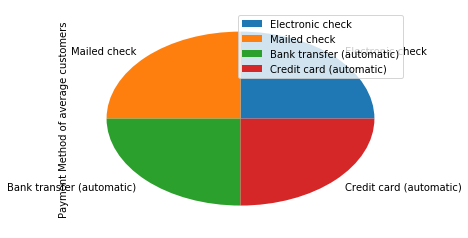

In [26]:
# Distribution of the payment methods of average customers
Payment = pd.DataFrame({'Payment Method of average customers' : [len(loyal_top50.PaymentMethod=='Electronic check'),
                                                    len(loyal_top50.PaymentMethod=='Mailed check'),
                                                    len(loyal_top50.PaymentMethod=='Bank transfer (automatic)'),
                                                    len(loyal_top50.PaymentMethod=='Credit card (automatic)')]}, 
                       index = ['Electronic check', 'Mailed check','Bank transfer (automatic)','Credit card (automatic)'])
Payment.plot.pie(y = 'Payment Method of average customers')

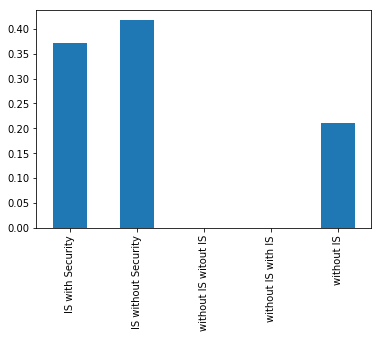

In [30]:
Internet_Security_VIP = pd.DataFrame([len(loyal_top10[(loyal_top10.InternetService != "No") & (loyal_top10.OnlineSecurity == 'Yes')])/len(loyal_top10),
                                  len(loyal_top10[(loyal_top10.InternetService != "No") & (loyal_top10.OnlineSecurity == 'No')])/len(loyal_top10),
                                  len(loyal_top10[(loyal_top10.InternetService == "No") & (loyal_top10.OnlineSecurity == 'No')])/len(loyal_top10),
                                  len(loyal_top10[(loyal_top10.InternetService == "No") & (loyal_top10.OnlineSecurity == 'Yes')])/len(loyal_top10),
                                  len(loyal_top10[(loyal_top10.InternetService == "No")])/len(loyal_top10)],
                                 index = ['IS with Security', 'IS without Security', 'without IS witout IS',
                                          'without IS with IS', 'without IS'])
Internet_Security_VIP.plot.bar(legend = False)

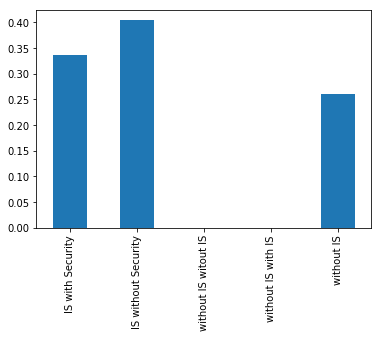

In [31]:
Internet_Security_avgcus = pd.DataFrame([len(loyal_top50[(loyal_top50.InternetService != "No") & (loyal_top50.OnlineSecurity == 'Yes')])/len(loyal_top50),
                                  len(loyal_top50[(loyal_top50.InternetService != "No") & (loyal_top50.OnlineSecurity == 'No')])/len(loyal_top50),
                                  len(loyal_top50[(loyal_top50.InternetService == "No") & (loyal_top50.OnlineSecurity == 'No')])/len(loyal_top50),
                                  len(loyal_top50[(loyal_top50.InternetService == "No") & (loyal_top50.OnlineSecurity == 'Yes')])/len(loyal_top50),
                                  len(loyal_top50[(loyal_top50.InternetService == "No")])/len(loyal_top50)],
                                 index = ['IS with Security', 'IS without Security', 'without IS witout IS',
                                          'without IS with IS', 'without IS'])
Internet_Security_avgcus.plot.bar(legend = False)